In [1]:
!git clone https://github.com/taschoebli/uni2ts.git

Cloning into 'uni2ts'...
remote: Enumerating objects: 915, done.
remote: Counting objects: 100% (459/459), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 915 (delta 308), reused 271 (delta 252), pack-reused 456 (from 2)
Receiving objects: 100% (915/915), 8.25 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (438/438), done.


In [2]:
%cd uni2ts

/content/uni2ts


In [3]:
!pip install -e '.[notebook]'

Obtaining file:///content/uni2ts
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#!pip install uni2ts

In [1]:
!touch .env

In [2]:
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download
from sklearn.metrics import mean_absolute_error, r2_score

#from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

In [3]:
# Memory optimization
# Set CUDA memory management configuration to avoid fragmentation
# https://pytorch.org/docs/stable/notes/cuda.html#using-custom-memory-allocators-for-cuda
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
torch.cuda.empty_cache()

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"]

'expandable_segments:True'

In [4]:
# Helpers

# Filename extractor
def file_name_no_extension(filepath):
  # Extract the filename without the folder path
  filename_with_extension = os.path.basename(filepath)

  # Remove the `.csv` extension
  filename_without_extension = os.path.splitext(filename_with_extension)[0]

  return filename_without_extension

In [ ]:
# Put all pdfs in a folder and zip it
!TIMESTAMP=$(date +"%Y-%m-%d_%H-%M-%S") && \
  mkdir "$TIMESTAMP" && \
  mv *.pdf "$TIMESTAMP/" && \
  zip -r "$TIMESTAMP.zip" "$TIMESTAMP/"


  adding: 2025-02-07_13-20-29/ (stored 0%)
  adding: 2025-02-07_13-20-29/PL=336-CL=672-RMSE=2.0751-2024-08-31-moirai-1-1-R-large.pdf (deflated 19%)
  adding: 2025-02-07_13-20-29/PL=4-CL=16-RMSE=2.5522-2024-08-31-moirai-1-1-R-large.pdf (deflated 33%)
  adding: 2025-02-07_13-20-29/PL=96-CL=192-RMSE=1.8511-2024-08-31-moirai-1-1-R-large.pdf (deflated 27%)
  adding: 2025-02-07_13-20-29/PL=24-CL=192-RMSE=1.4927-2024-08-31-moirai-1-1-R-large.pdf (deflated 32%)
  adding: 2025-02-07_13-20-29/PL=12-CL=12-RMSE=3.3786-2024-08-31-moirai-1-1-R-large.pdf (deflated 33%)
  adding: 2025-02-07_13-20-29/PL=12-CL=96-RMSE=2.2886-2024-08-31-moirai-1-1-R-large.pdf (deflated 33%)
  adding: 2025-02-07_13-20-29/PL=336-CL=2688-RMSE=2.0893-2024-08-31-moirai-1-1-R-large.pdf (deflated 19%)
  adding: 2025-02-07_13-20-29/PL=4-CL=8-RMSE=2.8903-2024-08-31-moirai-1-1-R-large.pdf (deflated 33%)
  adding: 2025-02-07_13-20-29/PL=12-CL=48-RMSE=5.8572-2024-08-31-moirai-1-1-R-large.pdf (deflated 33%)
  adding: 2025-02-07_13-20

In [171]:
# Definitions and Constants
#FILEPATH = "/content/uni2ts/230401_250108_PT1H_Solcast_All.csv"
FILEPATH = "/content/uni2ts/230401_250108_PT1H_Solcast_reduced_features.csv"
PREDICTION_LENGTH = 12 # Use the past 4, 12, 24, 48, 96, 336 time steps for prediction (4 hours to 14 days)
PREDICTION_START_DATETIME_STR = "2024-08-31 08:00:00"
PREDICTION_START_DATE_STR = PREDICTION_START_DATETIME_STR.split(" ")[0]
CONTEXT_LENGTH = PREDICTION_LENGTH * 4 # Use 1, 2, 4 and 8 fold PREDICTION_LENGTH
PATCH_SIZE = 32 # patch size, Number of samples for each layer or sequence, 32 or 64 recommended for hourly
BATCH_SIZE = 16 # batch size, samples processed in parallel
LR = "nA"
NUM_EPOCHS = "nA"
LOSS = "nA" # Enter manually later

# Model parameters
MODEL = "moirai-1.1-R"  # model name: choose from {'moirai-1.1-R', 'moirai-moe-1.0-R'}
SIZE = "base"  # model size: choose from {'small', 'base', 'large'}
MOIRAI_MODEL_STR = f"Salesforce/{MODEL}-{SIZE}"
MOIRAI_MODEL_PATH_SAFE = MOIRAI_MODEL_STR.replace("Salesforce/", "").replace("/", "-").replace(".", "-")

In [129]:
# Step 1: Load the data
df = pd.read_csv(FILEPATH, index_col=0, parse_dates=True)

In [ ]:
# Normalizer
#from sklearn.preprocessing import MinMaxScaler

 # Exclude the 'date' column from normalization
#date_column = df['date']  # Preserve the 'date' column
#features = df.drop(columns=['date'])  # Drop 'date' column for normalization

# Normalize the features
#scaler = MinMaxScaler()
#normalized_features = scaler.fit_transform(df)

In [ ]:
# Convert back to DataFrame with columns and index
#normalized_df = pd.DataFrame(normalized_features, columns=df.columns, index=df.index)

In [ ]:
#normalized_df

In [ ]:
#dataset = PandasDataset(dict(df))

In [130]:
## Step 2: Feature Scaling
# https://ts.gluon.ai/dev/api/gluonts/gluonts.dataset.pandas.html
# Convert into GluonTS dataset with features
#dataset = PandasDataset(df,target="dc_power",timestamp="date", freq="5T", past_feat_dynamic_real=['air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti', 'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate', 'relative_humidity', 'surface_pressure', 'snow_depth', 'snow_water_equivalent', 'snow_soiling_rooftop', 'snow_soiling_ground', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith'])
#dataset = PandasDataset(normalized_df,target="dc_power", past_feat_dynamic_real=['air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti', 'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate', 'relative_humidity', 'surface_pressure', 'snow_depth', 'snow_water_equivalent', 'snow_soiling_rooftop', 'snow_soiling_ground', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith'])
#dataset = PandasDataset(df, target="dc_power",
                        #past_feat_dynamic_real=['dc_power','air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti', 'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate', 'relative_humidity', 'surface_pressure', 'snow_depth', 'snow_water_equivalent', 'snow_soiling_rooftop', 'snow_soiling_ground', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith'],
                        #feat_dynamic_real=['air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti', 'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate', 'relative_humidity', 'surface_pressure', 'snow_depth', 'snow_water_equivalent', 'snow_soiling_rooftop', 'snow_soiling_ground', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith'])
dataset = PandasDataset(df, target="dc_power",
                        past_feat_dynamic_real=['dc_power','air_temp', 'azimuth', 'cloud_opacity', 'dhi', 'dni', 'ghi', 'zenith'],
                        feat_dynamic_real=['air_temp', 'azimuth', 'cloud_opacity', 'dhi', 'dni', 'ghi', 'zenith'])

In [172]:
# Step 3: Split data into training and testing sets
# Step 4: Create test sequences for time-series prediction
#TESTDATA_LENGTH = math.floor(len(df)*0.2) # 20% testdata

training_data, test_gen = split(dataset, date=pd.Period(PREDICTION_START_DATETIME_STR, freq="1H"))
test_data = test_gen.generate_instances(prediction_length=PREDICTION_LENGTH, windows=1)

In [ ]:
# Helper
from gluonts.dataset.util import to_pandas


def highlight_entry(entry, color):
    start = entry["start"]
    end = entry["start"] + len(entry["target"])
    plt.axvspan(start, end, facecolor=color, alpha=0.2)


def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(original_dataset, training_dataset):
        to_pandas(original_entry).plot()
        highlight_entry(train_entry, "red")
        plt.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in original_dataset:
        for test_input, test_label in test_pairs:
            to_pandas(original_entry).plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()

In [ ]:
# Visualizer
# https://ts.gluon.ai/stable/tutorials/data_manipulation/dataset_splitting_example.html
#plot_dataset_splitting(dataset, training_data, test_data)

In [39]:
# Step5.1: Prepare pre-trained model by downloading model weights from huggingface hub
if "moirai-moe" in MOIRAI_MODEL_STR:
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(MOIRAI_MODEL_STR),
        prediction_length=PREDICTION_LENGTH,
        context_length=CONTEXT_LENGTH,
        patch_size=PATCH_SIZE,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=dataset.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=dataset.num_past_feat_dynamic_real,
    )
    print("MOE used")

else:
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(MOIRAI_MODEL_STR),
        prediction_length=PREDICTION_LENGTH,
        context_length=CONTEXT_LENGTH,
        patch_size=PATCH_SIZE,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=dataset.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=dataset.num_past_feat_dynamic_real,
    )
    print("No MOE used")


No MOE used


In [173]:
# Step5.2: Prepare fine-tuned model by loading model weights from ckpt file
checkpoint_path = "/content/multirun/2025-02-11/15-40-14/0/checkpoints/epoch=13-step=1400.ckpt"

# Load the model
model = MoiraiForecast.load_from_checkpoint(checkpoint_path,
      prediction_length=PREDICTION_LENGTH,
      context_length=CONTEXT_LENGTH,
      patch_size=PATCH_SIZE,
      num_samples=100,
      target_dim=1,
      feat_dynamic_real_dim=dataset.num_feat_dynamic_real,
      past_feat_dynamic_real_dim=dataset.num_past_feat_dynamic_real)

In [174]:
# Step 6: Get probabilistic predictions
predictor = model.create_predictor(batch_size=BATCH_SIZE)
forecasts = list(predictor.predict(test_data.input))

In [175]:
# Step 7: Get point predictions
# Get predictions from forecasts
predictions = forecasts[0].mean_ts
# Feature added here!!!
# Truncate negative predictions to 0
predictions = np.maximum(predictions, 0)

# Get actuals for metric calculations later
actuals = df.loc[PREDICTION_START_DATETIME_STR:].iloc[:PREDICTION_LENGTH]["dc_power"]

# Change type
predictions = predictions.to_numpy()
actuals = actuals.to_numpy()

In [176]:
# Get prediction intervals
lower_50 = forecasts[0].quantile(0.25)  # 25th percentile (lower bound)
upper_50 = forecasts[0].quantile(0.75)  # 75th percentile (upper bound)
lower_90 = forecasts[0].quantile(0.05)  # 5th percentile (lower bound)
upper_90 = forecasts[0].quantile(0.95)  # 95th percentile (upper bound)


In [177]:
# Step 8: Do evaluations
# Calculate metrics

def smape(y_true, y_pred):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE).
    y_true: array-like, actual values
    y_pred: array-like, predicted values
    """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_values = np.abs(y_true - y_pred) / denominator
    smape_values = np.nan_to_num(smape_values, nan=0.0, posinf=0.0, neginf=0.0)  # Handle division by zero
    return np.mean(smape_values) * 100  # Convert to percentage


RMSE = np.sqrt(np.mean((predictions - actuals)**2))
MAE = mean_absolute_error(actuals, predictions)
#MAPE = np.mean(np.abs((actuals - predictions) / actuals)) * 100
R2 = r2_score(actuals, predictions)
SMAPE = smape(actuals, predictions)

# Print metrics
print(f"RMSE: {RMSE:.4f}")
print(f"MAE: {MAE:.4f}")
#print(f"MAPE: {MAPE:.2f}%")
print(f"SMAPE: {SMAPE:.2f}%")
print(f"R^2: {R2:.4f}")

RMSE: 2.5914
MAE: 2.2446
SMAPE: 55.90%
R^2: 0.4593


In [178]:
LR = 1e-7
NUM_EPOCHS = 13
DROPOUT_P = 0.2

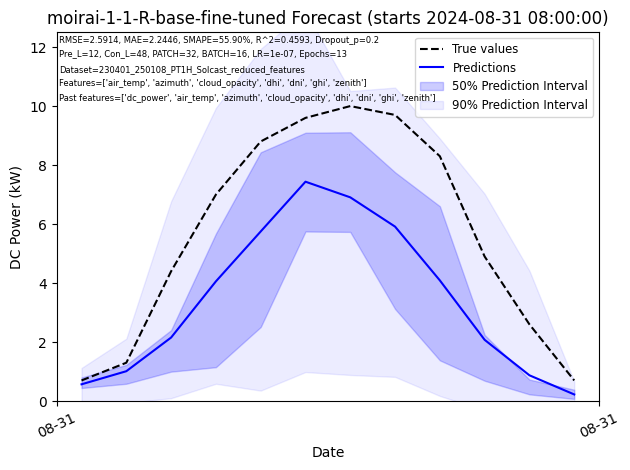

In [179]:
# Step 9: Visualize predictions first plot

# Plot filtered data
plt.plot(df[PREDICTION_START_DATETIME_STR:]["dc_power"].iloc[:PREDICTION_LENGTH], color="black", linestyle="--", label="True values")
plt.plot(df[PREDICTION_START_DATETIME_STR:].iloc[:PREDICTION_LENGTH].index, predictions[len(predictions)-len(df[PREDICTION_START_DATETIME_STR:].iloc[:PREDICTION_LENGTH]):], color="blue", label="Predictions")

# Add 50% Prediction Interval (Shaded)
plt.fill_between(
    df[PREDICTION_START_DATETIME_STR:].iloc[:PREDICTION_LENGTH].index,
    lower_50[len(lower_50)-len(df[PREDICTION_START_DATETIME_STR:].iloc[:PREDICTION_LENGTH]):],
    upper_50[len(upper_50)-len(df[PREDICTION_START_DATETIME_STR:].iloc[:PREDICTION_LENGTH]):],
    color="blue", alpha=0.2, label="50% Prediction Interval"
)

# Add 90% Prediction Interval (Shaded)
plt.fill_between(
    df[PREDICTION_START_DATETIME_STR:].iloc[:PREDICTION_LENGTH].index,
    lower_90[len(lower_90)-len(df[PREDICTION_START_DATETIME_STR:].iloc[:PREDICTION_LENGTH]):],
    upper_90[len(upper_90)-len(df[PREDICTION_START_DATETIME_STR:].iloc[:PREDICTION_LENGTH]):],
    color="blue", alpha=0.075, label="90% Prediction Interval"
)

plt.legend(loc="upper right", fontsize="small")
plt.ylabel("DC Power (kW)")
plt.xlabel("Date")
plt.title(f"{MOIRAI_MODEL_PATH_SAFE}-fine-tuned Forecast (starts {PREDICTION_START_DATETIME_STR})")
plt.figtext(0.1, 0.9000,f"RMSE={RMSE:.4f}, MAE={MAE:.4f}, SMAPE={SMAPE:.2f}%, R^2={R2:.4f}, Dropout_p={DROPOUT_P}", fontsize=6, color='black')
plt.figtext(0.1, 0.8700,f"Pre_L={PREDICTION_LENGTH}, Con_L={CONTEXT_LENGTH}, PATCH={PATCH_SIZE}, BATCH={BATCH_SIZE}, LR={LR}, Epochs={NUM_EPOCHS}", fontsize=6, color='black')
plt.figtext(0.1, 0.8400,f"Dataset={file_name_no_extension(FILEPATH)}", fontsize=6, color='black')
plt.figtext(0.1, 0.8100,f"Features={dataset.feat_dynamic_real}", fontsize=6, color='black')
plt.figtext(0.1, 0.7800,f"Past features={dataset.past_feat_dynamic_real}", fontsize=6, color='black')

# Set y-axis limits
plt.ylim(0, 12.5)

# Set y-axis limits and x-axis formatting
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=25)

# Adjust layout and save plot
plt.tight_layout()
plt.savefig(f"PL={PREDICTION_LENGTH}-CL={CONTEXT_LENGTH}-RMSE={RMSE:.4f}-{PREDICTION_START_DATE_STR}-{MOIRAI_MODEL_PATH_SAFE}.pdf")
plt.show()

In [10]:
# Fine-tuning in regards to https://github.com/SalesforceAIResearch/uni2ts/blob/main/README.md#fine-tuning
# Step 1 Set Data Path Directory
!echo "CUSTOM_DATA_PATH=/content/uni2ts/" >> .env

In [11]:
!echo "PYTHONPATH=/content/uni2ts" >> .env

In [12]:
!cat .env

CUSTOM_DATA_PATH=/content/uni2ts/
PYTHONPATH=/content/uni2ts


In [13]:
# Step 2.1 process dataset
!python -m uni2ts.data.builder.simple customdataset /content/uni2ts/230401_250108_PT1H_Solcast_reduced_features.csv --dataset_type wide_multivariate

Inferred frequency: H. Using this value for the 'freq' parameter.
Generating train split: 1 examples [00:00,  4.58 examples/s]
Saving the dataset (1/1 shards): 100% 1/1 [00:00<00:00, 263.00 examples/s]


In [14]:
# Step 2.2 Set offset
!python -m uni2ts.data.builder.simple customdataset /content/uni2ts/230401_250108_PT1H_Solcast_reduced_features.csv --date_offset '2024-08-31 07:00:00'

                     dc_power  air_temp  azimuth  cloud_opacity  dhi  dni  ghi  zenith
date                                                                                  
2023-04-01 01:00:00       0.0         8      -27           37.4    0    0    0     125
2023-04-01 02:00:00       0.0         8      -43           46.6    0    0    0     120
2023-04-01 03:00:00       0.0         8      -57           40.6    0    0    0     112
2023-04-01 04:00:00       0.0         7      -70           47.6    0    0    0     103
2023-04-01 05:00:00       0.0         7      -81           58.2    0    0    0      93
...                       ...       ...      ...            ...  ...  ...  ...     ...
2024-08-31 03:00:00       0.0        19      -55            0.0    0    0    0     107
2024-08-31 04:00:00       0.0        19      -67           16.5    0    0    0      98
2024-08-31 05:00:00       0.0        19      -79           39.8    7    0    7      88
2024-08-31 06:00:00       0.0        19    

In [ ]:
#!mv content/uni2ts/cli content/uni2ts/src/uni2ts/

In [ ]:
# Step 3 (move cli dir to src/uni2ts first!!!!)
# Set Batch size here /content/uni2ts/src/uni2ts/cli/conf/finetune/default.yaml to lower value
# For moirai large with A100 40GB RAM use 16 as batch size in val_dataloader and train_dataloader section

#!python -m uni2ts.cli.train -cp conf/finetune run_name=example_run model=moirai_1.1_R_large data=etth1 val_data=etth1

In [143]:
# Use Hydra's Sweeping Feature for Hyperparameter Search
!python -m uni2ts.cli.train --multirun -cp conf/finetune run_name=example_run model=moirai_1.1_R_base data=customdataset val_data=customdataset \
  model.module_kwargs.dropout_p=0.2 \
  trainer.max_epochs=25 \
  model.lr=1e-7 \
  train_dataloader.batch_size=24 \
  val_dataloader.batch_size=24

[2025-02-11 15:40:14,959][HYDRA] Launching 1 jobs locally
[2025-02-11 15:40:14,959][HYDRA] 	#0 : run_name=example_run model=moirai_1.1_R_base data=customdataset val_data=customdataset model.module_kwargs.dropout_p=0.2 trainer.max_epochs=25 model.lr=1e-07 train_dataloader.batch_size=24 val_dataloader.batch_size=24
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[2025-02-11 15:40:16,903][datasets][INFO] - PyTorch version 2.4.1 available.
[2025-02-11 15:40:16,903][datasets][INFO] - TensorFlow version 2.18.0 available.
[2025-02-11 15:40:16,904][datasets][INFO] - JAX version 0.4.33 available.
Seed set to 0
2025-02-11 15:40:17.397359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739288417.422296   43645 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register 

In [ ]:
# Show Tensorboard with results
#%load_ext tensorboard
#%tensorboard --logdir /content/multirun


In [ ]:
#Export outputs
#!zip -r outputs.zip /content/outputs

In [ ]:
# Evaluation
#!python -m uni2ts.cli.eval run_name=example_eval_1 model=moirai_1.0_R_small model.patch_size=32 model.context_length=1000 data=etth1_val

In [ ]:
#import gc

# Invoke garbage collector
#gc.collect()

# Clear GPU cache
#torch.cuda.empty_cache()